In [1]:
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
from typing import Any

In [3]:
SEED = 42
random.seed(SEED)

In [4]:

def df_metrics(**kwargs):
    return pd.DataFrame(kwargs, index = [0])

Read data
junction_aa - RBD sequence data
Antibody - type of antibody target to RBD
Label - 1 bind, 0 not-bind

In [5]:
whole_train = pd.read_csv('../dataset/whole_train.csv')

In [6]:
whole_test = pd.read_csv('../dataset/whole_test.csv')

In [7]:
REGN33_train = whole_train.loc[whole_train['Antibody']=='REGN33']
REGN33_train

,junction_aa,consensus_count,Label,Distance,Antibody
433767,GNTGFNCYCPIKNYGFQRTGGLGW,1,0,10,REGN33
433768,KNTGFNCYLPLVRYGFQTTAGGDW,1,0,9,REGN33
433769,KNTGFNCYRPLNTYGFWRTSGINY,1,1,9,REGN33
433770,KNKGFNCYDPITRYGFWPTNGSNW,1,0,9,REGN33
433771,KNRGFNCYGPLVAYGFQRTCGMGW,1,0,8,REGN33
...,...,...,...,...,...
553980,KNRGFNCYFPLLPYGFHTTFGIGW,1,0,8,REGN33
553981,KNQGFNCYPPIMAYGFFTTSGRDW,1,1,11,REGN33
553982,VVKKFNCYDPLVHYGFQRTTGLGY,4,0,10,REGN33
553983,KNQGFNCYAPLRHYGFWRTGGRGY,2,1,8,REGN33


In [8]:
REGN33_test = whole_test.loc[whole_test['Antibody']=='REGN33']
REGN33_test

,junction_aa,consensus_count,Label,Distance,Antibody
48197,KNAGFNCYTPLKQYGFWRTGGRNW,1,1,10,REGN33
48198,KNKGFNCYSPLYAYGFWRTQGEGF,1,0,9,REGN33
48199,KNRGFNCYSPLRRYGFWTTAGMGW,1,0,9,REGN33
48200,TGTGFNCYNPLCTYGFQRTVGRNW,1,0,11,REGN33
48201,KNKGFNCYAPLSPYGFWPTAGRGW,2,1,8,REGN33
...,...,...,...,...,...
61550,RRAGFNCYTPIVSYGFWPTGGQSW,1,0,11,REGN33
61551,KNEGFNCYSPIGRYGFHRTDGKNW,1,1,10,REGN33
61552,PQRGFNCYFPIASYGFWRTVGKDY,1,0,10,REGN33
61553,KRTGFNCYRPILGYGFWPTAGVGW,1,0,9,REGN33


One-hot encoding sequence

In [9]:
def encode_seq(sequence: str) -> np.ndarray:
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

Process dataframe to get one-hot encoded features of RBD sequence and labels.

In [10]:
def process_df(df: pd.DataFrame, col_seq: str) -> tuple[Any, Any]:
    features = df.loc[:, col_seq].apply(lambda x: encode_seq(x)).to_numpy()
    X_features = []
    for arr in features:
        X_features.append(list(arr.reshape(-1)))
    X_features = np.array(X_features)
    labels = df.loc[:, "Label"].to_numpy()
    return X_features, labels


In [11]:
X_train, y_train = process_df(REGN33_train, 'junction_aa')
X_test, y_test = process_df(REGN33_test, 'junction_aa')

Calculation all regression metrics

In [12]:
def calculate_metrics(y_pred_cl: np.ndarray, y_pred_log: np.ndarray, y_true: np.ndarray):
    acc = metrics.accuracy_score(y_true, y_pred_cl)
    prec = metrics.precision_score(y_true, y_pred_cl)
    rec = metrics.recall_score(y_true, y_pred_cl)
    auc = metrics.roc_auc_score(y_true, y_pred_log)
    f1_ = metrics.f1_score(y_true, y_pred_cl)
    return acc, prec, rec, f1_, auc

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)

In [14]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
y_pred_cl = rf.predict(X_test)
y_pred_log = rf.predict_proba(X_test)[:, 1]

In [16]:
acc, prec, rec, f1_, auc = calculate_metrics(y_pred_cl, y_pred_log, y_test)

In [17]:
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.913535,0.903821,0.92536,0.914463,0.968384


Train catboost and find important positions in RBD sequence

In [18]:
model = CatBoostClassifier(random_seed=SEED, verbose = False)

In [19]:
model.fit(X_train, y_train)

In [20]:
y_pred_cl = model.predict(X_test)
y_pred_log = model.predict_proba(X_test)[:, 1]

In [21]:
acc, prec, rec, f1_, auc = calculate_metrics(y_pred_cl, y_pred_log, y_test)
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)

In [22]:
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.922294,0.908379,0.939149,0.923508,0.972941


In [23]:
def find_relevant_pos(model: object) -> list[int]:
    feature_importance = model.feature_importances_
    st = 0
    chunks = []
    # split features of RBD sequence per position
    for i in range(20, len(feature_importance)+1, 20):
        chunks.append(feature_importance[st:i])
        st += 20
    # check if importance all aminoacid in current position equals to zero
    exclude_pos = []
    for i in range(len(chunks)):
        if all(chunks[i] == 0):
            exclude_pos.append(i)
    return exclude_pos



In [24]:
exclude_pos = find_relevant_pos(model)
exclude_pos

[4, 5, 6, 7, 9, 13, 14, 15, 18, 20]

Exclude none-relevant positions in sequence

In [26]:
def process_seq(seq: str) -> str:
    reduce_seq = ''.join([seq[i] for i in range(len(seq)) if i not in exclude_pos])
    return reduce_seq

In [27]:
REGN33_train['reduce_seq'] = REGN33_train['junction_aa'].apply(lambda x: process_seq(x))

/tmp/ipykernel_6625/327408045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REGN33_train['reduce_seq'] = REGN33_train['junction_aa'].apply(lambda x: process_seq(x))


In [28]:
REGN33_test['reduce_seq'] = REGN33_test['junction_aa'].apply(lambda x: process_seq(x))

/tmp/ipykernel_6625/1157606153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REGN33_test['reduce_seq'] = REGN33_test['junction_aa'].apply(lambda x: process_seq(x))


In [29]:
REGN33_test

,junction_aa,consensus_count,Label,Distance,Antibody,reduce_seq
48197,KNAGFNCYTPLKQYGFWRTGGRNW,1,1,10,REGN33,KNAGTLKQWRGRNW
48198,KNKGFNCYSPLYAYGFWRTQGEGF,1,0,9,REGN33,KNKGSLYAWRQEGF
48199,KNRGFNCYSPLRRYGFWTTAGMGW,1,0,9,REGN33,KNRGSLRRWTAMGW
48200,TGTGFNCYNPLCTYGFQRTVGRNW,1,0,11,REGN33,TGTGNLCTQRVRNW
48201,KNKGFNCYAPLSPYGFWPTAGRGW,2,1,8,REGN33,KNKGALSPWPARGW
...,...,...,...,...,...,...
61550,RRAGFNCYTPIVSYGFWPTGGQSW,1,0,11,REGN33,RRAGTIVSWPGQSW
61551,KNEGFNCYSPIGRYGFHRTDGKNW,1,1,10,REGN33,KNEGSIGRHRDKNW
61552,PQRGFNCYFPIASYGFWRTVGKDY,1,0,10,REGN33,PQRGFIASWRVKDY
61553,KRTGFNCYRPILGYGFWPTAGVGW,1,0,9,REGN33,KRTGRILGWPAVGW


In [30]:
X_train, y_train = process_df(REGN33_train, 'reduce_seq')

In [31]:
model = CatBoostClassifier(random_seed=SEED, verbose = False)

In [32]:
model.fit(X_train, y_train)

In [33]:
X_test, y_test = process_df(REGN33_test, 'reduce_seq')

In [34]:
y_pred_cl = model.predict(X_test)
y_pred_log = model.predict_proba(X_test)[:, 1]

In [35]:
acc, prec, rec, f1_, auc = calculate_metrics(y_pred_cl, y_pred_log, y_test)
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)

In [36]:
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.922294,0.908379,0.939149,0.923508,0.972941


As we can see metrics don't differ significantly, positions in exclude_pos are not important for the classification task

Let's visualize distribution of aminoacid per position between bind and not-bind RBD variants

In [37]:
non_bind_REGN33 = REGN33_train[REGN33_train.Label==0]
bind_REGN33 = REGN33_train[REGN33_train.Label==1]

In [38]:
seq_zeros_REGN33 = np.array(non_bind_REGN33['junction_aa'].tolist())
seq_ones_REGN33  = np.array(bind_REGN33['junction_aa'].tolist())

In [39]:
def def_value():
    return 0

In [40]:
def calculate_distr_aa(sequences: list):
    distr_aa = defaultdict(list)
    for seq in sequences:
        for i in range(len(seq)):
            distr_aa[i].append(seq[i])
            
    freq_per_pos = defaultdict(dict)
    for pos in distr_aa:
        aa, counts = np.unique(distr_aa[pos], return_counts=True)
        count = dict(zip(aa, counts))
        freq_per_pos[pos] = defaultdict(def_value, count)
    return freq_per_pos
        
        
    

In [42]:
freq_zeros_Ly16 = calculate_distr_aa(seq_zeros_REGN33)
freq_ones_Ly16 = calculate_distr_aa(seq_ones_REGN33)


In [43]:
def plot_distr(pos, freq_ones, freq_zeros, name):
    X = set(freq_ones[pos].keys()).intersection(set(freq_zeros[pos].keys()))
    bind = [freq_ones[pos][aa] for aa in X]
    non_bind = [freq_zeros[pos][aa] for aa in X]
    X_axis = np.arange(len(X))
    plt.bar(X_axis - 0.2, bind, 0.4, label = 'binding')
    plt.bar(X_axis + 0.2, non_bind, 0.4, label = 'non-binding')
    plt.xticks(X_axis, X)
    plt.xlabel("Aminoacid")
    plt.ylabel("Frequency")
    plt.title(f"Frequency aminoacids in {pos} position of {name} variant")
    plt.legend()
    plt.show()

Plot frequency distribution of aminoacid per position between bind and not-bind RBD variants

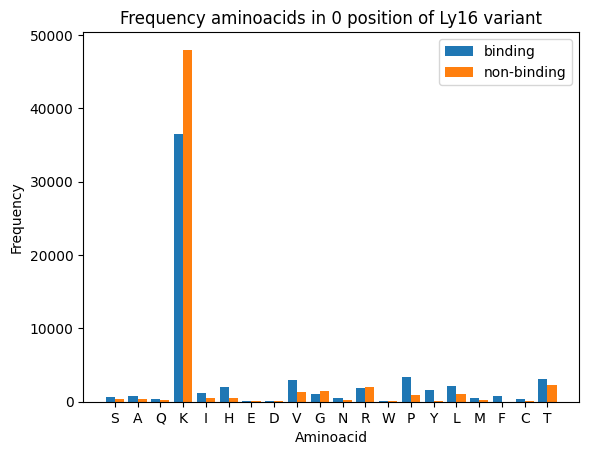

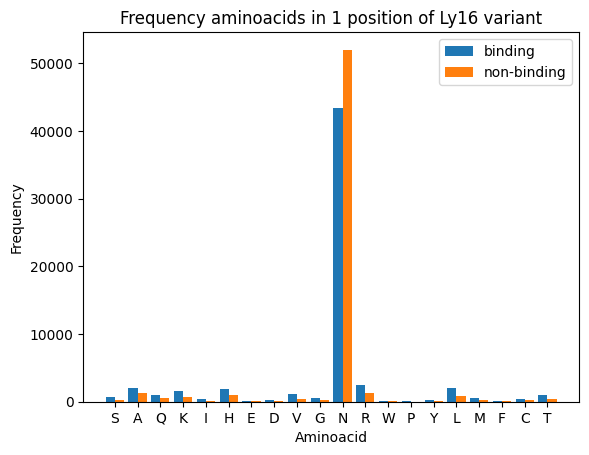

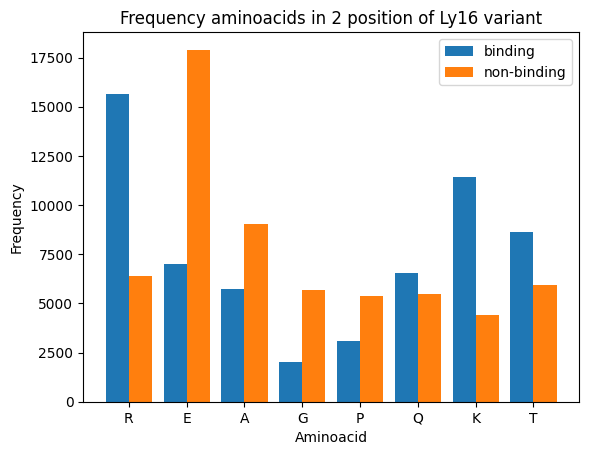

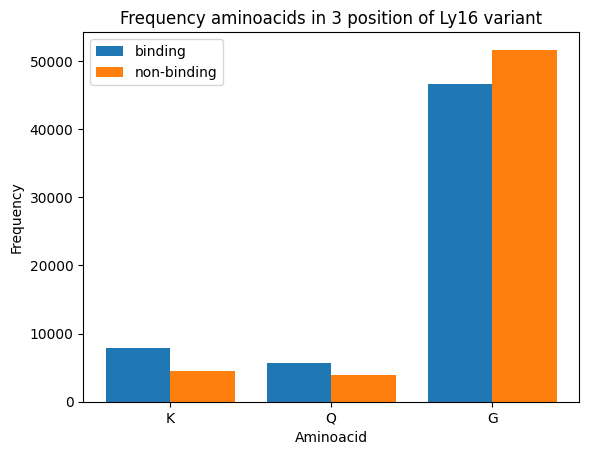

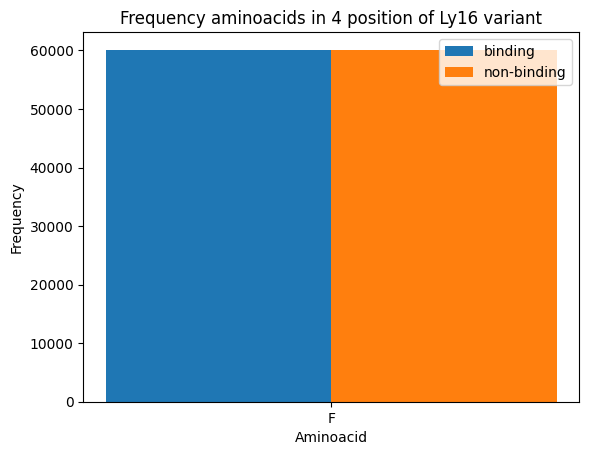

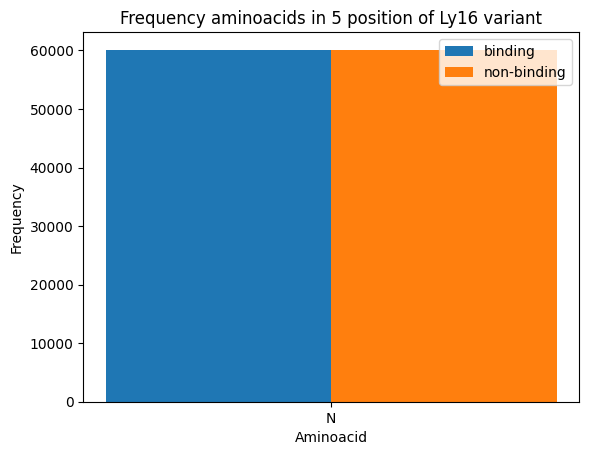

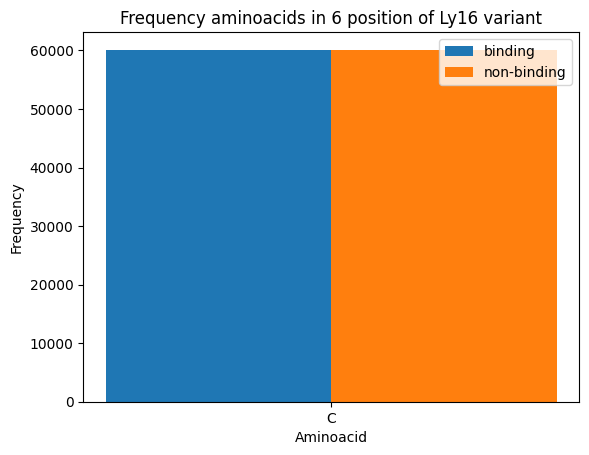

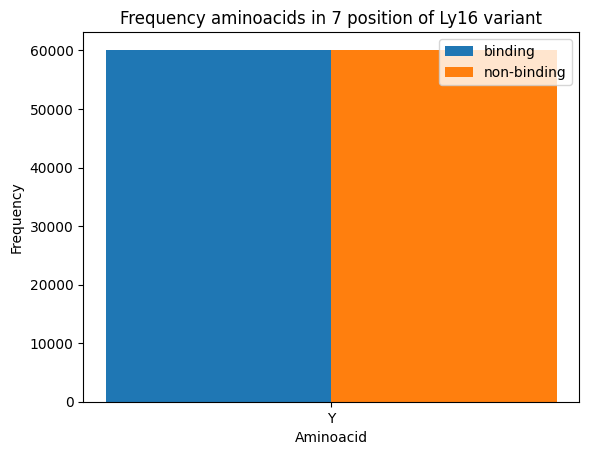

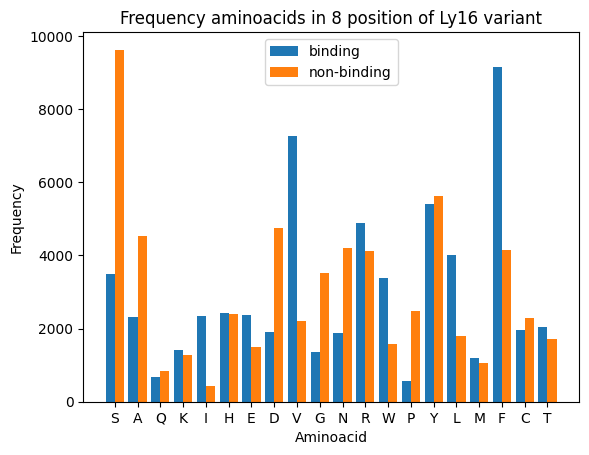

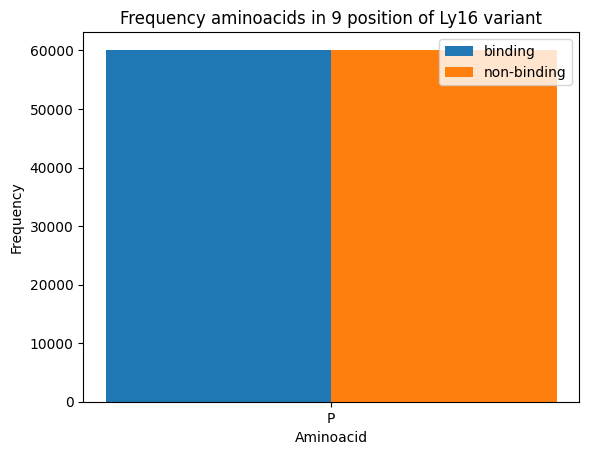

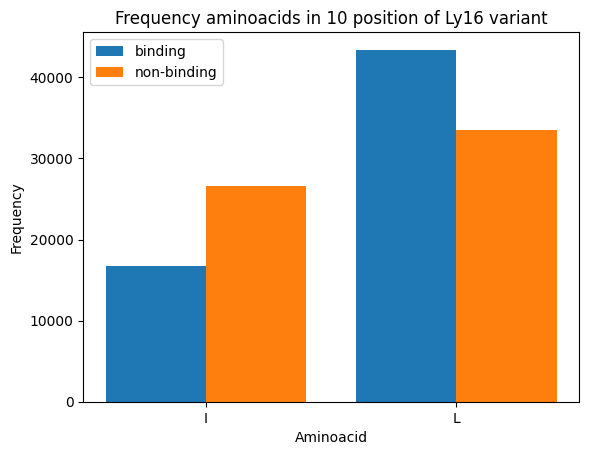

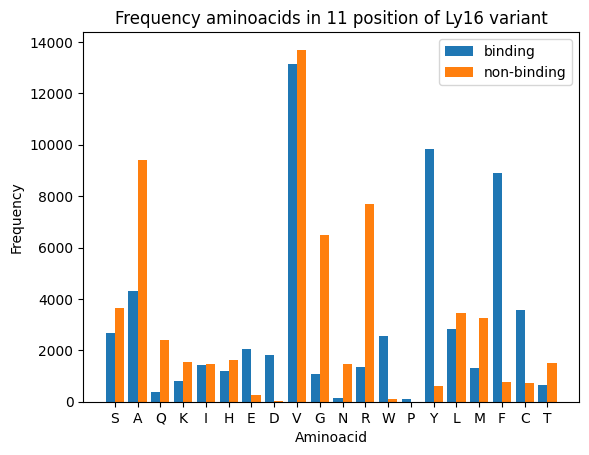

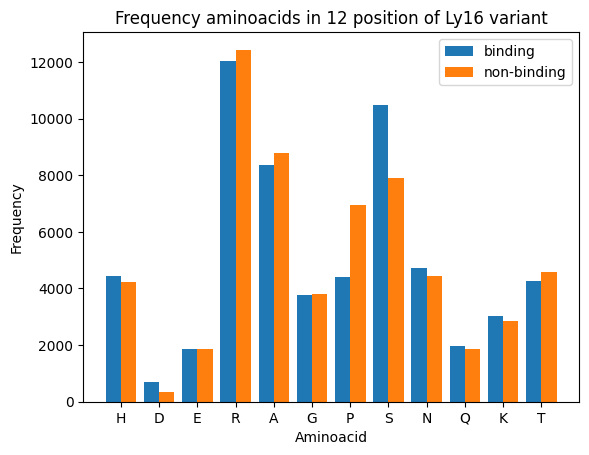

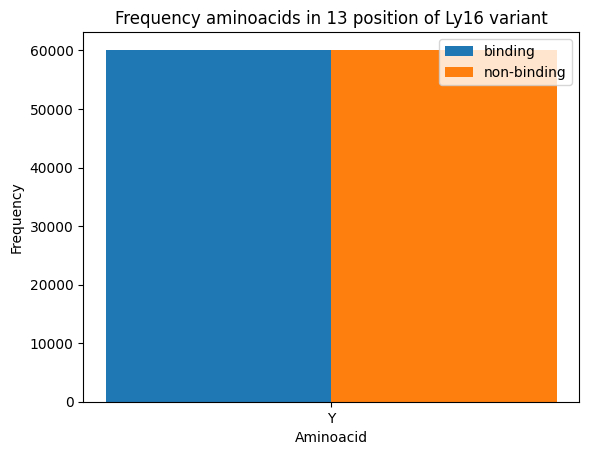

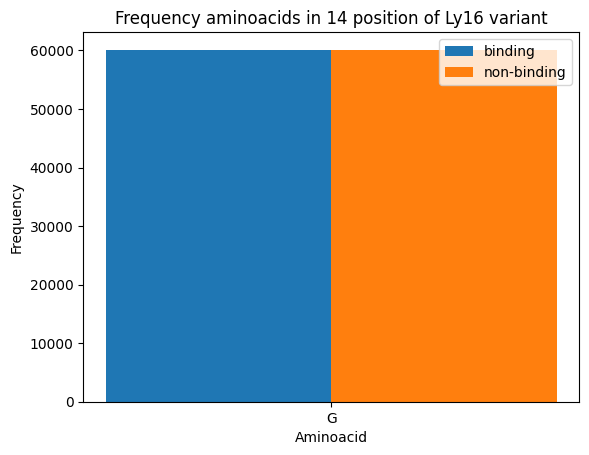

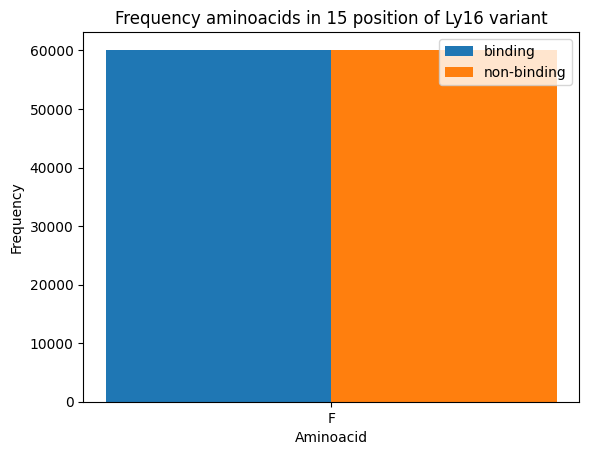

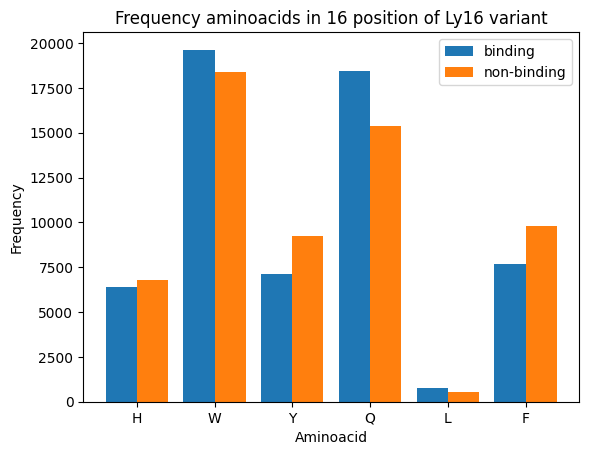

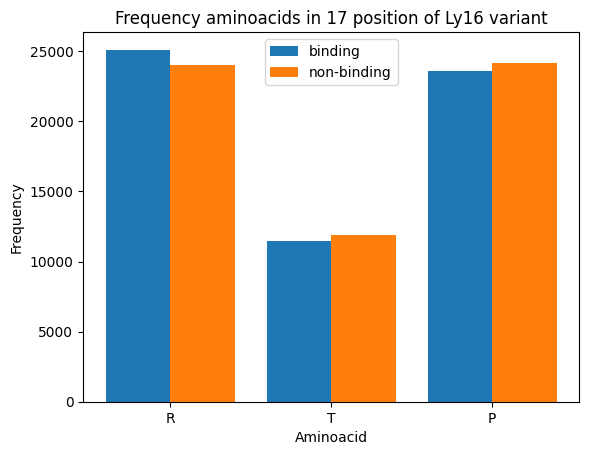

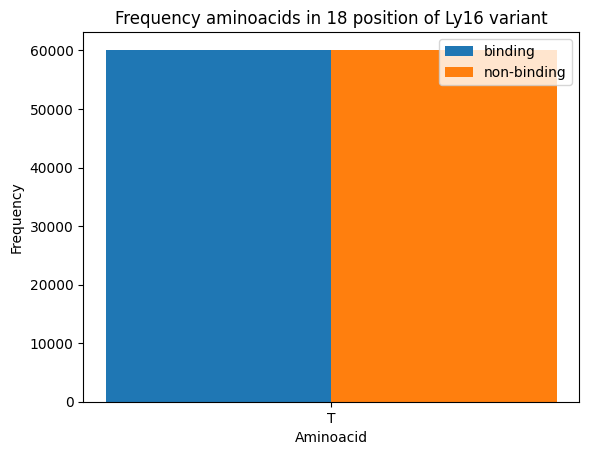

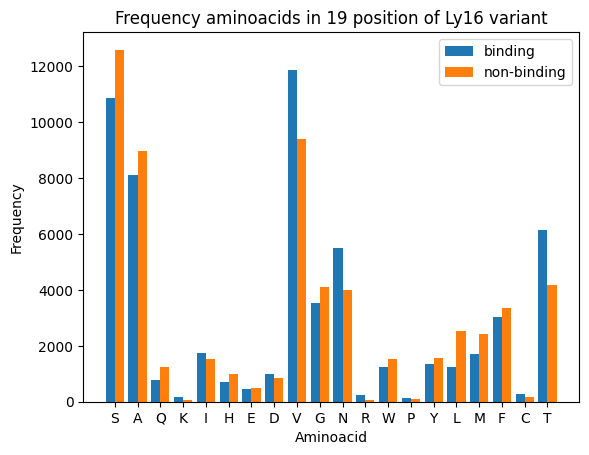

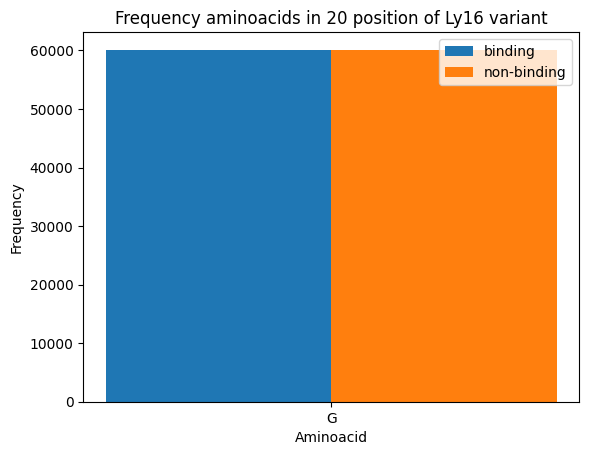

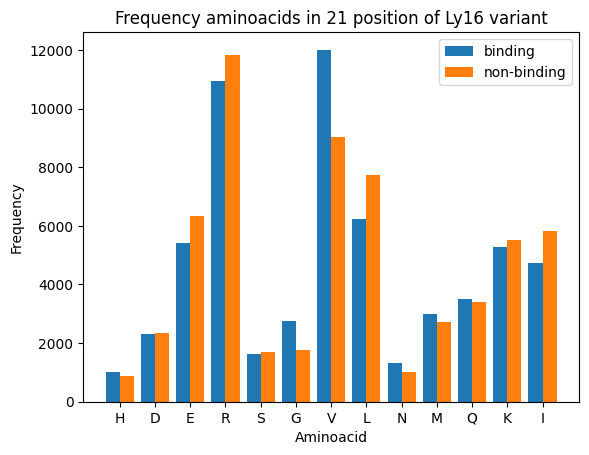

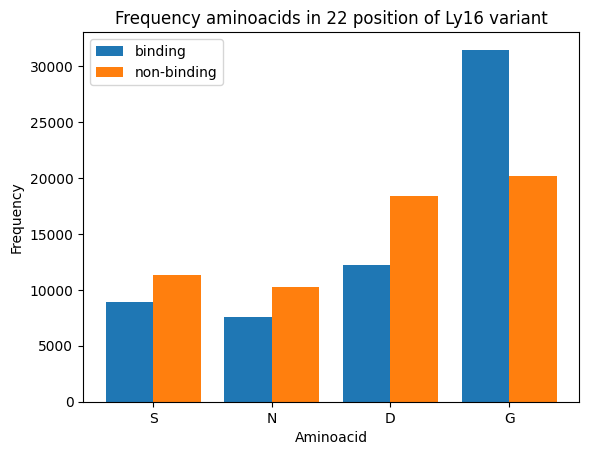

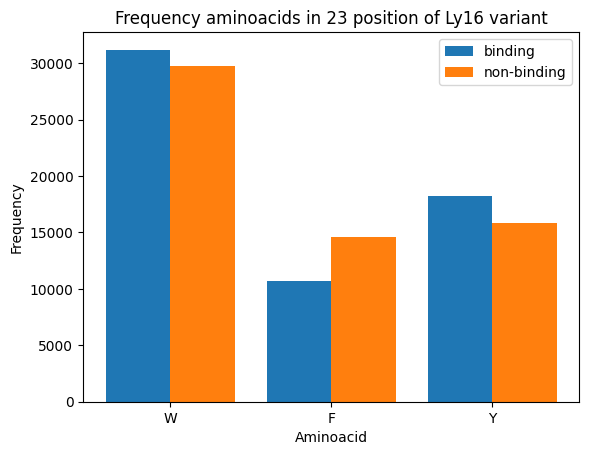

In [44]:
for pos in range(24):
    plot_distr(pos, freq_zeros_Ly16, freq_ones_Ly16, 'Ly16')


In [45]:
exclude_pos

[4, 5, 6, 7, 9, 13, 14, 15, 18, 20]

As we can see RBD sequence in positions (exclude_pos) have only one constant aminoacid